#  Equity Portfolio Management

### Data Preparation

Download the historial daily data of the entire 2018 for the 10 stocks 


```python
universe = ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN', 'FB', 'NFLX', 'TSLA', 'ORCL', 'SAP']
```

For example, to download IBM data, use the following link to go to yahoo finance page. Find the "Download Data" link to download the csv file to you local disk.
https://finance.yahoo.com/quote/IBM/history?period1=1514782800&period2=1546232400&interval=1d&filter=history&frequency=1d

Replace "IBM" with other stock symbol in the above URL, you will be able to download data for other 9 stocks.

You should have 10 csv files on your disk now. IBM.csv, MSFT.csv, etc. We call the 10 stocks "universe" which is the entire stock market you can trade.


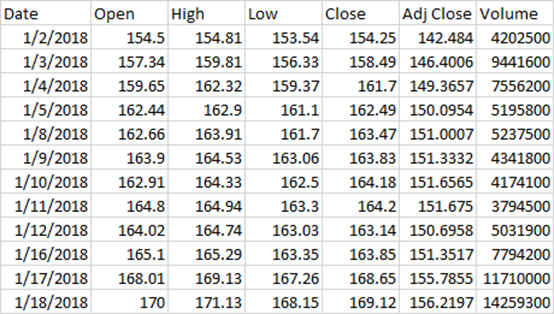


### Retrieve the "Close" and "Adj Close" values for each stock

You will create a dataframe where there are 20 columns for the 10 stocks, each row is the "Close" and "Adj Close" prices for the 10 stocks on each day, in the order of the business days in 2018. Assume all buy/sell on the "Close" prices and there is no transaction cost.

### You start to manage 5 million dollars fund on Jan 02, 2018

You have a strategy to manage the fund.

1. On Jan 02 2018, you split the \\$5m into 5 \\$1m, and use them to buy 5 stocks from the 10 stocks. For example, IBM close price was \\$154.25. With \\$1m, you can buy max 6482 shares with cost \\$999848.5 with \\$151.5‬ cash left. You decided to spend \\$1m on each of ['IBM', 'MSFT', 'GOOG', 'AAPL', 'AMZN'] respectively and keep the rest cash into a zero-interest cash account. On Jan 02 2018, your mark to market value (MTM) is \\$5m if combining all stocks value and cash. Your holdings of stocks and cach account is your portfolio.

\begin{equation*}
\ MTM^t =  cash^t + \sum_{k=1}^5 Shares_k^t \times ClosePrice_k^t \
\end{equation*}


2. Your trading strategy is "5 days rebalancing of buying low". Here is how it works. You keep your portfolio unchanged until 5 days later on Jan 09 2018. Now you want to re-check the market and adjust your portfolio. You will compute the "Adj Close" price changes from Jan 02 to Jan 09, and find the 5 stocks whose "Adj Close" prices dropped the most in terms of percentage. You sell all current holdings on Jan 09 "Close" prices to convert your portfolio to all cash. Then immediately split your cash, including your cash account, to 5 equal parts to buy the 5 stocks that dropped the most from Jan 02 to Jan 09 on 'Adj Close' prices. You always buy the max shares of stock on the "Close" price and keep the rest cash in cash account. Now the portfolio should be different from 5 days ago. This operation is called "rebalancing".

    Keep in mind, the MTM will change every day, even when your portfolio holdings don't change, because the stock prices change.


3. Corporations generally issue stock dividends on some days. The total dividend you get on such a day is the stock dividend  times your shares if you have shares of this stock on the dividend day. If you buy shares on the dividend day, these bought shares are not qualified to get dividend. If you sell shares on the dividend day, the sold shares are qualified to get dividend. For example, on 2/8/2018, IBM issued \$1.5 dividend per share. In your cash account, you will automatically get

\begin{equation*}
\$1.5 \times \left(your\ IBM\ shares\ on\ 2/8/2018\right)
\end{equation*} 



4. 5 business days later on Jan 17 (Jan 15 was a holiday), you re-check the market and adjust your portfolio again. You will have a new portfolio on Jan 17.


5. If you run this strategy every 5 days all the way to Dec 31 2018, you will have a daily MTM. You expect the MTM on Dec 31 2018 should be higher than \$5m because you always buy the stocks that dropped the most, i.e., you always buy low.


6. Another strategy is "5 days rebalancing of buying high". You always buy the 5 stocks whose "Adj Close" prices surge the most in terms of percentage because you believe the trend will continue. Run the new strategy and see how the MTM will change.


7. You will create a "high tech index" which is simply the daily average of the 10 stocks "Close" prices. Compare your MTM series with the "high tech index" and plot their curves. To plot the two curves together, you may want to convert the series to daily percentage change with regard to Jan 02 2018.


8. Download the USD/JPY 2018 historical data at https://www.myfxbook.com/en/forex-market/currencies/USDJPY-historical-data then use the "Close" column as the rate to convert your MTM series from USD to JPY. Plot the two MTM curves. You will need to convert to daily percentage change too.


9. The above two strategies both rebalance every 5 days. Try to change the days interval and find the optimal days interval that maximizes the MTM on 12/31/2018. 




## Prerequisites

#### Library Configurations
* dplyr
    - Used for filtering and data frame manipulation
* ggplot2
    - Used for graphing and intricate observations of data
* grid
    - Used for graphing and tabular features
* gridExtra
    - Used for grouping graphs and extra graphing features
* gtable
    - Used for ggplot table features
* plotly
    - Interactive functionality with graphs

In [54]:
#library imports
library(dplyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(gtable)
library(plotly)

In [16]:
# File imports
ibm = read.csv("IBM.csv", header=TRUE)[,c(1,5,6)]
msft = read.csv("MSFT.csv", header=TRUE)[,c(1,5,6)]
goog = read.csv("GOOG.csv", header=TRUE)[,c(1,5,6)]
amzn = read.csv("AMZN.csv", header=TRUE)[,c(1,5,6)]
meta = read.csv("META.csv", header=TRUE)[,c(1,5,6)]
nflx = read.csv("NFLX.csv", header=TRUE)[,c(1,5,6)]
tsla = read.csv("TSLA.csv", header=TRUE)[,c(1,5,6)]
orcl = read.csv("ORCL.csv", header=TRUE)[,c(1,5,6)]
sap = read.csv("SAP.csv", header=TRUE)[,c(1,5,6)]
aapl = read.csv("AAPL.csv", header=TRUE)[,c(1,5,6)]

foreignExchange = read.csv("USDJPY.csv", header=TRUE)

#### Load the stocks to their respective data frames
A total of 10 stock data frames is created, each containing columns **Date | Close | Adj.Close**
<br></br>
No manipulation is required for the foreign exchange csv data frame

#### Containerization and Organization
2 lists (containers) are created to keep track of all stock data frames:
* stockContainer
    - Keeps track of current stocks we have and will be updated each rebalancing day
* universalContainer
    - A reference container of all stocks


In [24]:
stockContainer = list(ibm, msft, goog, aapl, amzn)
names(stockContainer) = c("IBM", "MSFT", "GOOG", "AAPL", "AMZN")

universalContainer = list(ibm, msft, goog, aapl, amzn, 
                          meta, nflx, tsla, orcl, sap)

names(universalContainer) = c("IBM", "MSFT", "GOOG",
                             "AAPL", "AMZN", "META", 
                              "NFLX", "TSLA", "ORCL", "SAP")

# For display purposes
lapply(universalContainer, head, n = 3)

,Date,Close,Adj.Close
,<chr>,<dbl>,<dbl>
1,2018-01-02,147.4665,114.6287
2,2018-01-03,151.5201,117.7796
3,2018-01-04,154.5889,120.1651
,Date,Close,Adj.Close
,<chr>,<dbl>,<dbl>
1,2018-01-02,85.95,80.94038
2,2018-01-03,86.35,81.31707
3,2018-01-04,87.11,82.03278
,Date,Close,Adj.Close


## SHAREPRICE Function
Returns Product of shares that can be purchased at a particular close price

Input:
1. Data frame of a stock,
2. Current iteration/date, 
3. Wallet Amount spendable towards stock


In [25]:
SHAREPRICE = function(stockFrame, iter=1, wallet=1000000)
{
    stockFrame = as.data.frame(stockFrame)
    closePrice = stockFrame["Close"][iter,]
    
    stockUnits = wallet / closePrice
    return(floor(stockUnits)*closePrice)
}

## CASHBALANCE Function
Returns: Cash amount remaining after purchasing a stock

Input:
1. Data frame of a stock,
2. Current iteration/date, 
3. Wallet Amount spendable towards stock

In [26]:
CASHBALANCE = function(stockFrame, iter=1, wallet=1000000)
{
    stockFrame = as.data.frame(stockFrame)
    closePrice = stockFrame["Close"][iter,]
    
    stockUnits = wallet / closePrice
    
    remainder = stockUnits - floor(stockUnits)
    cashBalance = remainder * closePrice
    
    return(cashBalance)
}

## STOCKUNITS Function
Returns: Max amount of stock units purchasable towards a stock

Input:
1. Data frame of a stock,
2. Current iteration/date, 
3. Wallet Amount spendable towards stock

In [27]:
STOCKUNITS = function(stockFrame, iter=1, wallet=1000000)
{
    stockFrame = as.data.frame(stockFrame)
    closePrice = stockFrame["Close"][iter,]
    
    stockUnits = wallet / closePrice
    return(floor(stockUnits))
}


## MTM_CALC Function
Returns: Market to market amount for current iteration/date

Input:
1. Data frame of a stock,
2. Current iteration/date, 
3. Wallet Amount spendable towards stock

In [28]:
MTM_CALC = function(portfolio, iter=1)
{
    cashBalance = portfolio[iter,2]
    sharePrice = portfolio[iter, 3]
    
    return(cashBalance + sharePrice)
}


## PERCENTMUTATOR Function
Returns: Mutated stockFrame with 2 columns of Percent Diff and Avg Percent Diff

Input:
1. Data frame of a stock,

In [29]:
PERCENTMUTATOR = function(stockFrame)
{
    adjClose = stockFrame[["Adj.Close"]]
    difference = (adjClose/lag(adjClose) - 1) * 100
    avgDifference = c(rep(NA, length(adjClose)))

    avg = mean(difference[(1:5)], na.rm=TRUE)
    avgDifference[6] = avg
    
    for(index in seq(from=11, to=length(adjClose), by=5))
    {
        avg = mean(difference[(index-5):(index-1)], na.rm=TRUE)
        avgDifference[index] = avg
    }    
    stockFrame = mutate(stockFrame, "Percent_Diff"=difference, "Avg_Percent_Diff"=avgDifference)
    return(stockFrame)
}

## DIVIDENT_CALC Function
Returns: Merged stockFrame with dividends of that stock throughout the year

Input:
1. Data frame of a stock,

In [30]:
DIVIDEND_CALC = function(stockFrame)
{
    
    date = stockFrame[["Date"]]
    date = date[2:length(date)]
    
    close = stockFrame[["Close"]]
    adj_close = stockFrame[["Adj.Close"]]
    
    ratio_close = close[1:(length(close)-1)] / close[2:length(close)]
    ratio_adj =  adj_close[1:(length(adj_close)-1)] / adj_close[2:length(adj_close)]

    dividend = abs(round((ratio_close - ratio_adj) * close[2:length(close)], 3))
    
    fullFrame = data.frame("Date"=date, "Dividend"=dividend)
    dividendFrame = filter(fullFrame, Dividend != 0)
    
    stockFrame = merge(stockFrame,dividendFrame,all.x=TRUE)
    
    return(stockFrame)  
}

## MTM_CALC Function
Returns: Sum of all products of stock units and stock dividends of that date

Input:
1. StockFrame of all stock Close and Adj.Close
2. stockUnitList List containing how many units of each stock currently owned
3. Current iteration/date

In [31]:
DIVIDEND_SUM = function(adjustedClose_Ref, stockUnitList, iter=1)
{
    dividendDays = lapply(adjustedClose_Ref, "[", iter,)

    totalDividendSum = 0
    
    for(name in names(dividendDays))
    {
        frame = as.data.frame(dividendDays[name])
        dividendAmount = frame[,6]

        if(!(is.na(dividendAmount)))
        {
            unitAmount = stockUnitList[[name]]
            totalDividendSum = totalDividendSum + (unitAmount * dividendAmount)
        }
    }
    return(totalDividendSum)
}

#### Controller Function
This function is continuously called and will make use of helper functions to perform portfolio calculations.

Returns: A vector of updated portfolio and new stocks to use post rebalancing day

Input:
1. Current stocks owned,
2. Data frame containing history of stock purchasing,
3. Current iteration/date,
4. Checks to see if current date is rebalancing day or not
5. Reference stockFrame of all stock Close and Adj.Close
6. List containing how many units of each stock currently owned
7. Flag for which strategy of stock purchasing will be used

In [32]:
PORTFOLIO_CALC = function(stockContainer, portfolio, iter=2, rebalanceFlag=1, adjustedClose_Ref=NA, stockUnitList=NA, descending=FALSE)
{
    
    wallet = portfolio[iter-1, 5]
    sharePrice = sum(unlist(lapply(stockContainer, SHAREPRICE, iter, wallet)))
    dividendDaySums = DIVIDEND_SUM(adjustedClose_Ref, stockUnitList, iter)
    cashAccumulation = portfolio[iter-1, 2]
    
    portfolio[iter,2] = cashAccumulation + dividendDaySums
    portfolio[iter,3] = sharePrice
    portfolio[iter, 5] = wallet

    mtm = MTM_CALC(portfolio, iter)
    
    portfolio[iter, 4] = mtm
    
    if(rebalanceFlag %% 5 != 0)
    {
        return(list(portfolio, NA))
    }
    else
    {
        
        # perform rebalancing operations
        portfolio[iter, 5] = portfolio[iter, 4] / 5 #dispersion
        sharePrice = sum(unlist(lapply(stockContainer, SHAREPRICE, iter, portfolio[iter, 5])))
        cashAccumulation = sum(unlist(lapply(stockContainer, CASHBALANCE, iter, portfolio[iter, 5])))
        
        portfolio[iter, 2] = cashAccumulation
        portfolio[iter, 3] = sharePrice        
        
        adjusted_ReferenceGuide = lapply(adjustedClose_Ref, "[", iter,5)
        
        orderedFrame = data.frame("Stock"=names(adjusted_ReferenceGuide), "Avg"=unlist(adjusted_ReferenceGuide))
        
        # Use strategy 1 or strategy 2
        if(!descending)
        {
            orderedFrame = arrange(orderedFrame, Avg)
        }
        else
        {
            orderedFrame = arrange(orderedFrame, desc(Avg))
        }
        return(list(portfolio, as.vector(orderedFrame[,1][1:5])))
    }
    
}

## Portfolio Generation
### Managing 5 million dollars fund on Jan 02, 2018
2 trading strategies can be implemented on our portfolio

1. 5 days rebalancing of buying low
2. 5 days rebalancing of buying high

<br><br/>
#### The following is a generation of a portfolio using **strategy 1**


In [33]:
universeLen = nrow(universalContainer[[1]])

dates = universalContainer[[1]]
dates = dates[["Date"]]

stockUnitList = lapply(universalContainer, STOCKUNITS)

portfolio_strat1 = data.frame("Date"=dates, 
                       "Cash_Balance"=rep(NA, universeLen),
                       "Sum_Share_Prices"=rep(NA, universeLen),
                       "MTM"=rep(NA, universeLen),
                      "Wallet_Per_Stock"=rep(NA, universeLen))

adjustedClose_Ref = lapply(universalContainer, PERCENTMUTATOR)
adjustedClose_Ref = lapply(adjustedClose_Ref, DIVIDEND_CALC)

portfolio_strat1[1,2] = sum(unlist(lapply(stockContainer, CASHBALANCE)))
portfolio_strat1[1,3] = sum(unlist(lapply(stockContainer, SHAREPRICE)))
portfolio_strat1[1,4] = MTM_CALC(portfolio_strat1)

portfolio_strat1[1,5] = 1000000
portfolio_strat1[2,5] = 1000000

rebalanceFlag = 1
for(i in (2:universeLen))
{
    
    # Receive vector of calculations    
    calculations = PORTFOLIO_CALC(stockContainer, portfolio_strat1, iter=i,
                                  rebalanceFlag, adjustedClose_Ref, 
                                  stockUnitList)
    
    portfolio_strat1 = calculations[[1]]
    newStocks = calculations[[2]]
        
    if(rebalanceFlag %% 5 != 0)
    {
        rebalanceFlag = rebalanceFlag + 1
    }
    else
    {
        
        # update stocks to buy
        rebalanceFlag = 1
        stockContainer = universalContainer[newStocks]
        names(stockContainer) = c(newStocks)
    }
}

#### The following is a generation of a portfolio using **strategy 2**

In [34]:
stockContainer = list(ibm, msft, goog, aapl, amzn)
names(stockContainer) = c("IBM", "MSFT", "GOOG", "AAPL", "AMZN")

universeLen = nrow(universalContainer[[1]])

dates = universalContainer[[1]]
dates = dates[["Date"]]

stockUnitList = lapply(universalContainer, STOCKUNITS)

portfolio_strat2 = data.frame("Date"=dates, 
                       "Cash_Balance"=rep(NA, universeLen),
                       "Sum_Share_Prices"=rep(NA, universeLen),
                       "MTM"=rep(NA, universeLen),
                      "Wallet_Per_Stock"=rep(NA, universeLen))

adjustedClose_Ref = lapply(universalContainer, PERCENTMUTATOR)
adjustedClose_Ref = lapply(adjustedClose_Ref, DIVIDEND_CALC)

# Need to do first row manually
portfolio_strat2[1,2] = sum(unlist(lapply(stockContainer, CASHBALANCE)))
portfolio_strat2[1,3] = sum(unlist(lapply(stockContainer, SHAREPRICE)))
portfolio_strat2[1,4] = MTM_CALC(portfolio_strat1)

portfolio_strat2[1,5] = 1000000
portfolio_strat2[2,5] = 1000000

rebalanceFlag = 1
for(i in (2:universeLen))
{
    
    # Receive vector of calculations    
    calculations = PORTFOLIO_CALC(stockContainer, portfolio_strat2, iter=i,
                                  rebalanceFlag, adjustedClose_Ref, 
                                  stockUnitList, TRUE)
    
    portfolio_strat2 = calculations[[1]]
    newStocks = calculations[[2]]
        
    if(rebalanceFlag %% 5 != 0)
    {
        rebalanceFlag = rebalanceFlag + 1
    }
    else
    {
        
        # update stocks to buy
        rebalanceFlag = 1
        stockContainer = universalContainer[newStocks]
        names(stockContainer) = c(newStocks)
    }
}

##### Generated Portfolios

In [35]:
cat("Portfolio 1", "\n")
head(portfolio_strat1, n = 16)

cat("Portfolio 2", "\n")
head(portfolio_strat2, n = 16)

Portfolio 1 


,Date,Cash_Balance,Sum_Share_Prices,MTM,Wallet_Per_Stock
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-01-02,178.7107,4999821,5000000,1000000
2,2018-01-03,178.7107,4999744,4999923,1000000
3,2018-01-04,178.7107,4999745,4999924,1000000
4,2018-01-05,178.7107,4999896,5000074,1000000
5,2018-01-08,178.7107,4999762,4999941,1000000
6,2018-01-09,204.1370,5003791,5003996,1000799
7,2018-01-10,204.1370,5003683,5003887,1000799
8,2018-01-11,204.1370,5003718,5003923,1000799
9,2018-01-12,204.1370,5003754,5003958,1000799


Portfolio 2 


,Date,Cash_Balance,Sum_Share_Prices,MTM,Wallet_Per_Stock
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-01-02,178.7107,4999821,5000000,1000000
2,2018-01-03,178.7107,4999744,4999923,1000000
3,2018-01-04,178.7107,4999745,4999924,1000000
4,2018-01-05,178.7107,4999896,5000074,1000000
5,2018-01-08,178.7107,4999762,4999941,1000000
6,2018-01-09,204.1370,5003791,5003996,1000799
7,2018-01-10,204.1370,5003874,5004079,1000799
8,2018-01-11,204.1370,5003703,5003907,1000799
9,2018-01-12,204.1370,5003648,5003852,1000799


## Observations
Here are the final observations we've made
#### High Tech Index
A High Tech Index is a daily average of the 10 stocks' **Close** prices.

In [36]:
closeValues = as.data.frame(lapply(universalContainer, '[[', "Close"))
htiFrame = mutate(closeValues, HTI = apply(closeValues, 1, mean))

htiFrame = mutate(htiFrame, HTI_PERCENT_CHANGE = 
                  round( ( (HTI - HTI[[1]]) / HTI[[1]] ) * 100, 3) )

head(htiFrame)

,IBM,MSFT,GOOG,AAPL,AMZN,META,NFLX,TSLA,ORCL,SAP,HTI,HTI_PERCENT_CHANGE
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,147.4665,85.95,53.2500,43.0650,59.4505,181.42,201.07,21.36867,46.63,112.39,95.20607,0.000
2,151.5201,86.35,54.1240,43.0575,60.2100,184.67,205.05,21.15000,47.71,113.31,96.71516,1.585
3,154.5889,87.11,54.3200,43.2575,60.4795,184.33,205.63,20.97467,48.18,115.05,97.39206,2.296
4,155.3442,88.19,55.1115,43.7500,61.4570,186.85,209.99,21.10533,48.47,116.33,98.65980,3.628
5,156.2811,88.28,55.3470,43.5875,62.3435,188.28,212.05,22.42733,48.98,114.80,99.23764,4.235
6,156.6252,88.22,55.3130,43.5825,62.6350,187.87,209.31,22.24600,49.06,114.16,98.90217,3.882


#### Comparing MTM Series with HTI
To scale, the MTM series has been converted to a daily percentage similar to HTI

In [37]:
MTM_strat1 = as.data.frame(portfolio_strat1["MTM"])
MTM_strat1 = round(((MTM_strat1 - MTM_strat1[1,]) / MTM_strat1[1,]) * 100, 3)
MTM_strat1 = rename(MTM_strat1, MTM_PERCENT_CHANGE_STRAT1 = MTM)
head(MTM_strat1)

MTM_strat2 = as.data.frame(portfolio_strat2["MTM"])
MTM_strat2 = round(((MTM_strat2 - MTM_strat2[1,]) / MTM_strat2[1,]) * 100, 3)
MTM_strat2 = rename(MTM_strat2, MTM_PERCENT_CHANGE_STRAT2 = MTM)
head(MTM_strat2)

,MTM_PERCENT_CHANGE_STRAT1
,<dbl>
1,0.000
2,-0.002
3,-0.002
4,0.001
5,-0.001
6,0.080


,MTM_PERCENT_CHANGE_STRAT2
,<dbl>
1,0.000
2,-0.002
3,-0.002
4,0.001
5,-0.001
6,0.080


#### Comparing HTI Over Both MTM Strategies
Below is a preparation of HTI over both MTM strategies

In [51]:
preparedHTI = data.frame(Date = as.Date(portfolio_strat1$Date),
                         HTI_Value = htiFrame$HTI_PERCENT_CHANGE,
                        MTM_strat1,MTM_strat2)

plot2aFrame = data.frame(Date = as.Date(portfolio_strat1$Date),
                         MTM_strat1 = MTM_strat1$MTM_PERCENT_CHANGE_STRAT1)

plot2bFrame = data.frame(Date = as.Date(portfolio_strat2$Date),
                         MTM_strat2 = MTM_strat2$MTM_PERCENT_CHANGE_STRAT2)


# Plot 1
preparedHTInew <- reshape2::melt(preparedHTI, id.vars="Date", na.rm = T)
plot1 = ggplot(data.frame(preparedHTInew),aes(x=Date, y=value, group=variable, colour = variable)) + 
geom_line(size=1) +
stat_smooth(aes(x = Date, y = value), 
            method = "lm") +
ggtitle("HTI Time Series") + 
theme(plot.title = element_text(hjust = 0.5)) +
labs(x = "Time", y = "High Tech Index",color = "Legend Title\n") + 
scale_color_manual(values = c("darkgreen", "red", "blue"))


# Plot 2a
plot2a = ggplot(plot2aFrame, aes(x = Date,
                                y = MTM_strat1)) +
geom_line(size=1) + 
stat_smooth(aes(x = Date,y = MTM_strat1), 
            method = 'lm') + 
ggtitle("MTM Time Series (Strategy 1)") + 
theme(plot.title = element_text(hjust=0.5)) + 
labs(x = "Time", y = "MTM Index")


# Plot 2b
plot2b = ggplot(plot2bFrame, aes(x = Date,
                                y = MTM_strat2)) +
geom_line(size=1) + 
stat_smooth(aes(x = Date,y = MTM_strat2), 
            method = 'lm') + 
ggtitle("MTM Time Series (Strategy 2)") + 
theme(plot.title = element_text(hjust=0.5)) + 
labs(x = "Time", y = "MTM Index")

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


##### MTM Series in USD and JPY
Using the `foreignExchange` data frame, prepare both MTM series in USD and JPY

In [52]:
foreignExchange$Date <- as.Date(as.character(foreignExchange$Date), format = "%m/%d/%y")
foreignExchange <- select(foreignExchange,Date,Close)

MTM_low <- portfolio_strat1 %>% mutate(pct_MTM = round(((MTM - MTM[1])*100/(MTM)),5))
MTM_low$Date <-as.character(MTM_low$Date)
MTM_low$Date <- as.Date(MTM_low$Date, format = "%Y-%m-%d")
y1<- select(MTM_low,Date,MTM,pct_MTM)
currency_df <- right_join(foreignExchange, y1, by="Date")
t<- currency_df %>% mutate("MTM_JPY"= Close*MTM, "pct_MTM_JPY"= round(((MTM_JPY - MTM_JPY[1])*100/(MTM_JPY[1])),5))%>% select(Date,pct_MTM,pct_MTM_JPY)
CURRENCY_DF <- reshape2::melt(t, id.vars="Date", na.rm = T)


# Plot 3
plot3 = ggplot(data.frame(CURRENCY_DF),aes(x=Date, y=value, group=variable, color=variable)) + 
geom_line(size=1) +
stat_smooth(aes(x = Date, y = value), 
            method = "loess") +
ggtitle("MTM Series in USD and JPY") + 
theme(plot.title = element_text(hjust = 0.5)) +
labs(x = "Time", y = "MTM", color = "Legend Title\n") +
scale_color_manual(labels = c("MTM_USD", "MTM_JPY"), values = c("red", "blue"))

### Bringing it all Together
Here are our observations

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


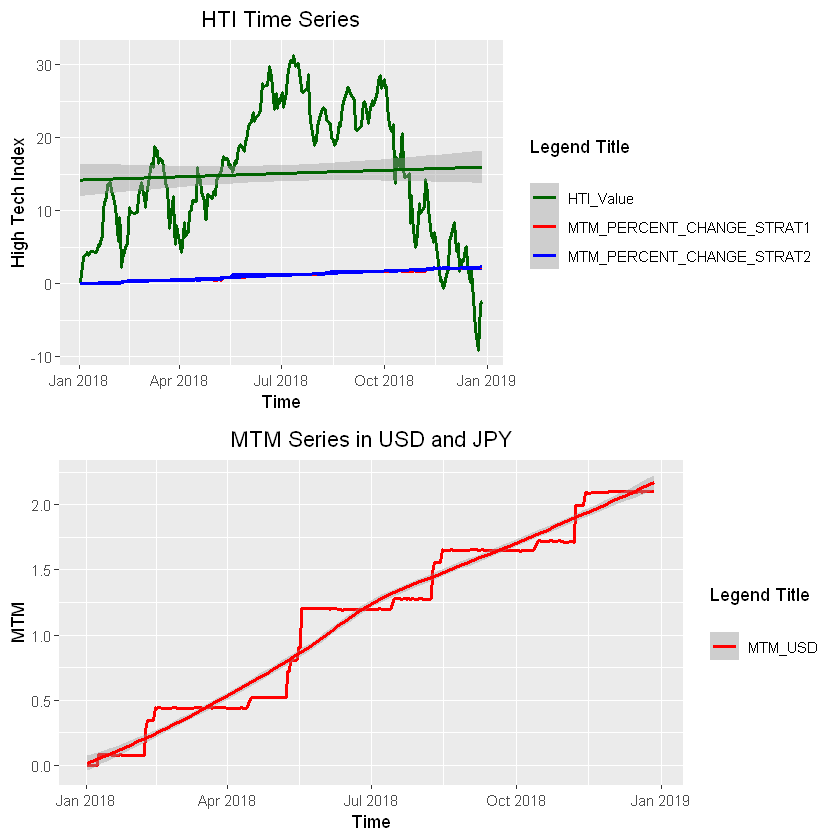

`geom_smooth()` using formula = 'y ~ x'


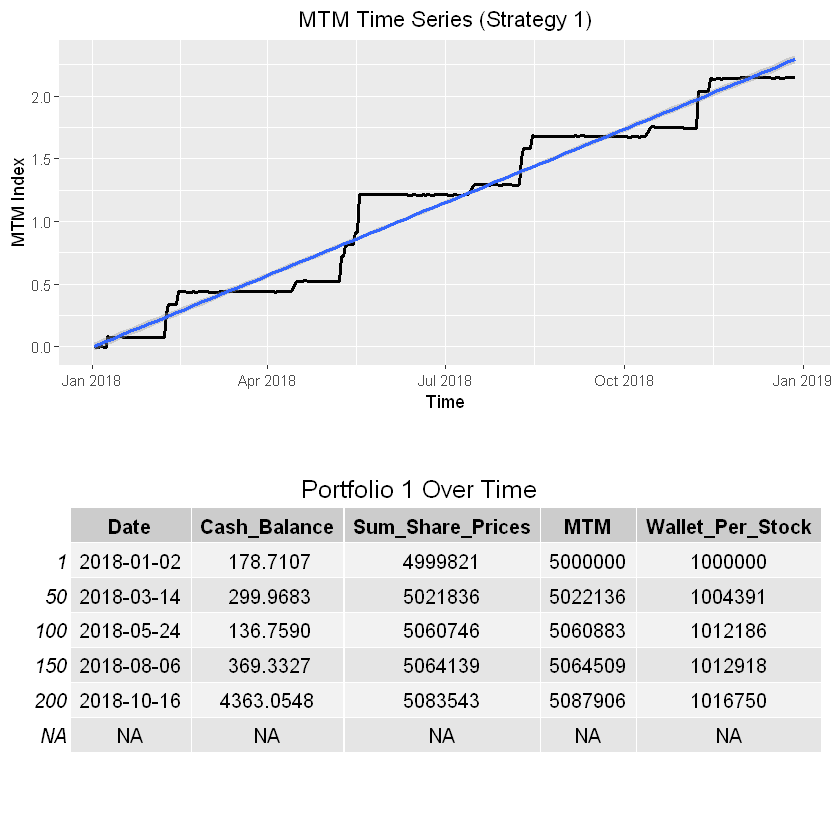

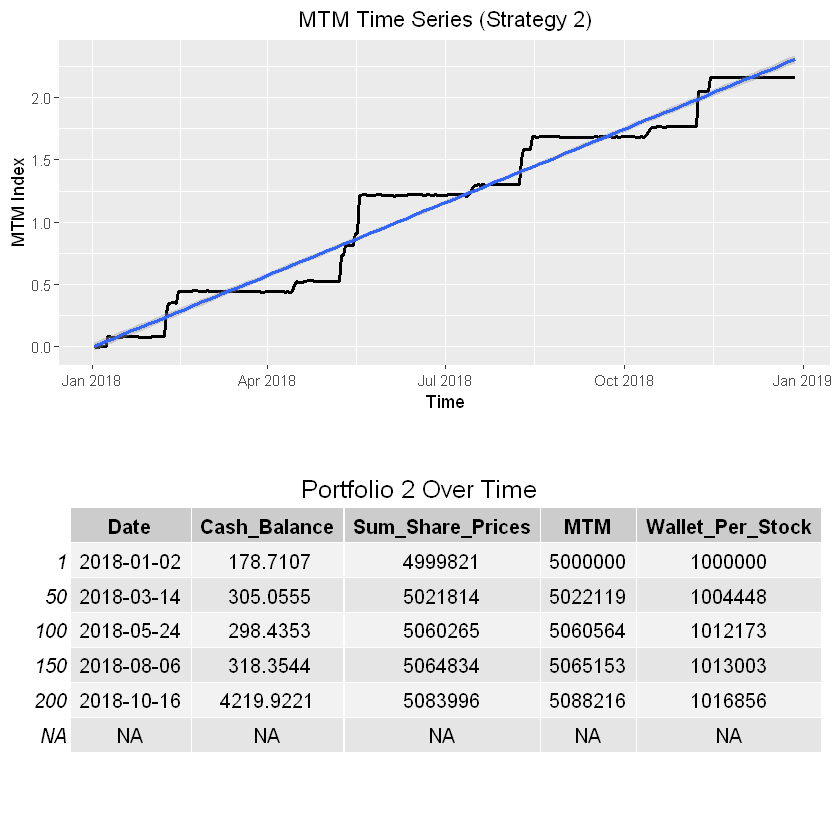

In [53]:
grob_portfolio1 = tableGrob(portfolio_strat1[c(1, 50, 100, 150, 200, 251),])
h1 = grobHeight(grob_portfolio1)
w1 = grobWidth(grob_portfolio1)

title1 = textGrob("Portfolio 1 Over Time", y=unit(0.5,"npc") + h1,
                 vjust=0, gp=gpar(fontsize=15))

table_portfolio1 = gTree(children=gList(grob_portfolio1, title1))

grob_portfolio2 = tableGrob(portfolio_strat2[c(1, 50, 100, 150, 200, 251),])
h2 = grobHeight(grob_portfolio2)
w2 = grobWidth(grob_portfolio2)

title2 = textGrob("Portfolio 2 Over Time", y=unit(0.5,"npc") + h2,
                 vjust=0, gp=gpar(fontsize=15))

table_portfolio2 = gTree(children=gList(grob_portfolio2, title2))

grid.arrange(plot1, plot3, nrow=2)
grid.arrange(plot2a, table_portfolio1, nrow=2)
grid.arrange(plot2b, table_portfolio2, nrow=2)